In [2]:
import tensorflow as tf
from tensorflow import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0-dev20240620
Keras version: 3.3.3.dev2024062303


In [3]:
import os
import numpy as np
import cv2


In [5]:
data_dir="data-FaceMaskDetection/"
categories = ["with_mask", "without_mask"]
img_size = 128

X = []
y= []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read the image
            resized_array = cv2.resize(img_array, (img_size, img_size))  # Resize to 128x128
            X.append(resized_array)
            y.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
X = np.array(X,dtype='float32')/255.0
y = np.array(y,dtype='int')

print(f"Data loaded: {len(X)} images , {len(y)} labels")



    

Data loaded: 7553 images , 7553 labels


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Training data: {len(X_train)} images, {len(y_train)} labels")
print(f"Test data: {len(X_test)} images, {len(y_test)} labels")



Training data: 6042 images, 6042 labels
Test data: 1511 images, 1511 labels


Data Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

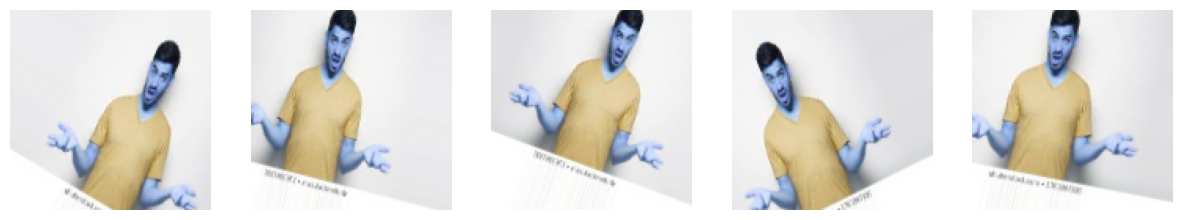

In [8]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

import matplotlib.pyplot as plt

sample_image = X_train[0]
sample_image = sample_image.reshape((1,) + sample_image.shape)

# Generate augmented images and display them
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i, batch in enumerate(datagen.flow(sample_image, batch_size=1)):
    if i == 5:  # Display 5 augmented images
        break
    axes[i].imshow(batch[0])
    axes[i].axis('off')

plt.show()


In [10]:
len(X_train)

6042

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


c:\Users\mahim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.7522 - loss: 0.6742 - val_accuracy: 0.8961 - val_loss: 0.2740
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.8983 - loss: 0.2511 - val_accuracy: 0.9153 - val_loss: 0.2262
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.9238 - loss: 0.1962 - val_accuracy: 0.9173 - val_loss: 0.2081
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.9365 - loss: 0.1543 - val_accuracy: 0.9153 - val_loss: 0.2227
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9645 - loss: 0.1037 - val_accuracy: 0.9318 - val_loss: 0.2060
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.9655 - loss: 0.0903 - val_accuracy: 0.9371 - val_loss: 0.2178
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.9788 - loss: 0.0553 - val_accuracy: 0.9418 - val_loss: 0.2299
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.9848 - loss: 0

In [11]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9341 - loss: 0.3037
Test Accuracy: 93.51%


In [20]:
import cv2

# Load the trained model
model = tf.keras.models.load_model('mask_detection_model.h5')

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)  # Use 0 for webcam, or replace with video file path

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        resized_face = cv2.resize(face, (img_size, img_size)) / 255.0
        resized_face = np.expand_dims(resized_face, axis=0)

        prediction = model.predict(resized_face)
        label = "Mask" if prediction < 0.5 else "No Mask"

        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    cv2.imshow("Face Mask Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [15]:
model.save('mask_detection_model.keras')


In [16]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('mask_detection_model.keras')

# Test the model
print(model.summary())  # To ensure the model loads correctly


c:\Users\mahim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  """Load the weights of a model from a filepath (.keras or .weights.h5).


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,177,349 (84.60 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,784,900 (56.40 MB)

None


In [19]:
model = tf.keras.models.load_model('mask_detection_model.h5')
